# Introduction
As a final step in fixing the biomass reaction, we will need to re-fit the growth associated maintanence (GAM) in the reaction to capture the amount of energy needed for the production of biomass. Beata originally already did this in her thesis, but as we've changed the biomass reaction quite a bit in the mean time we need to fit this again.

To do so, we will use the chemostat data presented in her thesis in figure 4.5. With this data we can minimize the error of the linear regression to estimate the best possible GAM that captures our data and model.

In [1]:
import cameo
import pandas as pd
import cobra.io
import escher
import copy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model = cobra.io.read_sbml_model('../model/g-thermo.xml')

## NGAM
Before we fit the GAM, we need to make sure the NGAM is still correct, as we've changed quite a bit in the model since we did this last time. Based on Beata's thesis, we know the intercept of figure 4.5, i.e. the amount of glucose consumed when the cell is not growing. This is then the sugar that is converted into energy which is used for maintanence. 

To estimate the NGAM, we will fix the glucose consumption rate to that measured at a growth rate of 0. We will then block biomass formation. We can set the objective of the model to maximize ATP maintenance. The flux through the ATPM reaction then should become the lower bound of this reaction as it represents the NGAM. 

In [4]:
with model:
    model.reactions.EX_glc__D_e.bounds = (-0.1551,0) #0.1551 mmol glucose/gCDW/h is consumed at a growth rate of 0
    model.reactions.biomass.bounds = (0,0)
    model.reactions.ATPM.bounds = (0,1000) #remove the original estimated NGAM that was given
    model.objective = 'ATPM'
    print(model.optimize())

<Solution 3.141 at 0x1877b34f188>


so the non-growth associated maintenance should be fixed at 3.141 mmolATP/gCDW/h. This will be set by fixing the lower bounds of the ATPM reaction to this flux t oforce this flux through, regardless of the growth rate.

In [5]:
model.reactions.ATPM.bounds = (3.141, 1000)

In [5]:
#save&commit
cobra.io.write_sbml_model(model,'../../model/g-thermo.xml')

## GAM
Now that we had fixed and fit the NGAM, we can move forward and fit the GAM to the model. 

For now I had to estimate the data from the image in Beata's thesis... This is not ideal. Martyn would look to see if he could find anything in the lab when they are allowed back in. 

In [3]:
#import data
df = pd.read_csv('../databases/Growth data.csv', sep = ';')
#should be in the long format

In [4]:
del df['Unnamed: 6']

In [5]:
del df['1 mm']
del df['corresponds to']
del df['0.074074074']
del df['mmol/gcdw/h']

In [6]:
df

,Growth rate,Glucose_consumption_1,Glucose_consumption_2,Glucose_consumption_3,Mean_glucose_consumption,st_dev
0,0.05,1.000000,1.148148,1.259259,1.135802,0.130070
1,0.10,1.703704,1.851852,2.014815,1.856790,0.155614
2,0.20,3.000000,3.111111,3.200000,3.103704,0.100206
3,0.40,5.925926,6.814815,7.962963,6.901235,1.021265


In [7]:
#add a function that will fit the gam
#GAM_list = list of GAMS to test, e.g. from 10 to 100 with an interval of 1. This will be changed with each iteration
#df = Data frame with each condition and the mean and stdev measured glucose consumption rates
def iteration(model, GAM_list, df):
    R_list = []
    for GAM in GAM_list:
        model_copy = copy.deepcopy(model) 
        model_copy.reactions.biomass.add_metabolites({
            model_copy.metabolites.atp_c: -GAM,
            model_copy.metabolites.adp_c: GAM,
            model_copy.metabolites.pi_c:GAM,
            model_copy.metabolites.h2o_c: -GAM,
            model_copy.metabolites.h_c: GAM}) 
        R = []
        for index,row in df.iterrows():
            fx_biomass = row['Growth rate']    #here call the condition set by the data frame in the above
            model_copy.reactions.biomass.bounds = (fx_biomass,fx_biomass)
            model_copy.reactions.biomass.objective_coefficient = 0 #remove biomass objective
            model_copy.reactions.EX_glc__D_e.objective_coefficient = 1 #minimize the Glucose uptake as objective
            vG = model_copy.optimize().objective_value #predictied glucose consumption to get the fixed growth rate for this GAM
            meanEXP = - row['Mean_glucose_consumption'] #mean measured glucose consumption rate for this growth rate 
            stdEXP = row['st_dev']#stdev at this growth rate
            R.append(abs(vG - meanEXP)/stdEXP) #calculate how far the predicted vG differs from the measured and store it in a list
        R_list.append(sum(R))
    #find the minimum from the list of GAMs tried
    smallest_R = min(R_list)
    #then find the GAM that associates to the smallest R
    find_index = R_list.index(smallest_R)
    best_GAM = GAM_list[find_index]
    plt.plot(GAM_list,R_list)
    plt.ylabel('R')
    plt.xlabel('GAM')
    return (best_GAM, plt.show)

In [8]:
#first remove the GAM from the model biomass reaction to start with a clean slate
model.reactions.biomass.add_metabolites({
    model.metabolites.atp_c: 104.9974,
    model.metabolites.adp_c: -104.9974,
    model.metabolites.pi_c:-104.9974,
    model.metabolites.h2o_c: 104.9974,
    model.metabolites.h_c: -104.9974
})

In [9]:
#Allow any glucose uptake
model.reactions.EX_glc__D_e.bounds = (-1000,0)

In [10]:
#1st iteration, going from 10 to 150, in intervals of 10
GAM_list1 = list(range(10,251,10))

(160, <function matplotlib.pyplot.show(*args, **kw)>)

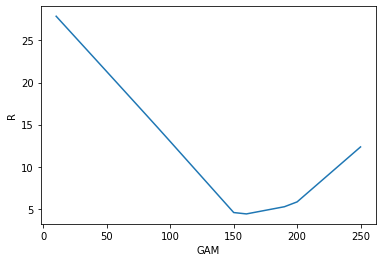

In [11]:
iteration(model,GAM_list1,df)

In [12]:
#2nd iteration, going from 150 to 170, in intervals of 1
GAM_list2 = list(range(150,171,1))

(153, <function matplotlib.pyplot.show(*args, **kw)>)

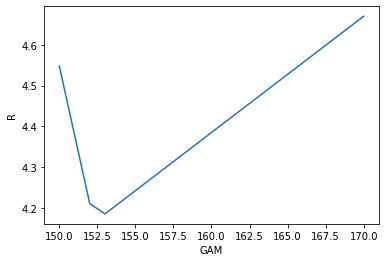

In [13]:
iteration(model,GAM_list2,df)

In [14]:
#third iteration, from 152 to 154, in intervals of 0.1
GAM_list3 = list(np.linspace(152,154,21))
#need a different function for this, as range will only take integers

(152.3, <function matplotlib.pyplot.show(*args, **kw)>)

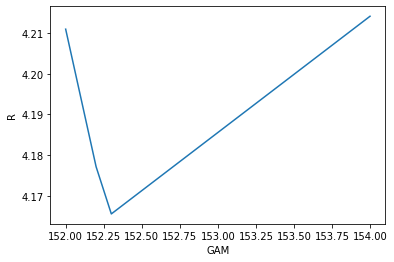

In [15]:
iteration(model,GAM_list3,df)

In [16]:
#last iteration
GAM_list4 = list(np.linspace(152.2,152.4,21))

(152.28, <function matplotlib.pyplot.show(*args, **kw)>)

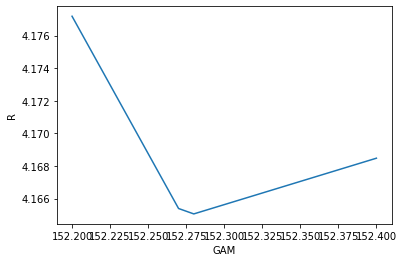

In [17]:
iteration(model,GAM_list4,df)

From the above, we can determine that the best fit GAM for our model is XXXX.
Now I will add this into our model and save & commit it.

In [ ]:
model.reactions.biomass.add_metabolites({
    model.metabolites.atp_c: - ,
    model.metabolites.adp_c: + ,
    model.metabolites.pi_c:-,
    model.metabolites.h2o_c: +,
    model.metabolites.h_c: -
})

# Finally, change the GAM in the model to the number selected here
# Check to be sure, biomass still adds up to 1g/g
152.28